<Figure size 600x400 with 0 Axes>

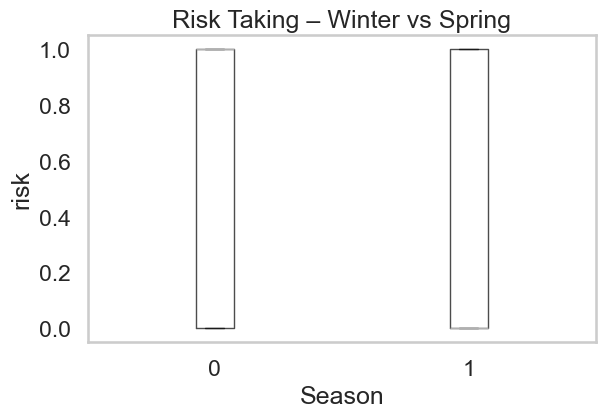

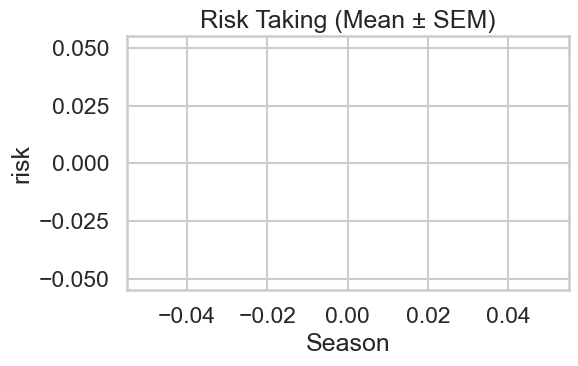

In [20]:
# Hamja’s Bat Seasonal Analysis – Winter vs Spring (dataset1.csv)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


# 1.LOAD & CLEAN DATA

df = pd.read_csv("dataset1.csv")
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

if "season" not in df.columns:
    raise KeyError("The dataset must contain a 'season' column with 'winter' and 'spring' values.")

# Normalize season text
def clean_season(s):
    if pd.isna(s): return np.nan
    s = str(s).strip().lower()
    if s.startswith("win"): return "winter"
    if s.startswith("spr"): return "spring"
    return s

df["season"] = df["season"].map(clean_season)

# Filter only Winter vs Spring
df_ws = df[df["season"].isin(["winter", "spring"])].copy()


# 2. DETECT BAT BEHAVIOUR COLUMNS

candidates = {
    "landing_numbers": ["bat_landing_number", "landing_numbers", "bat_landings", "landings"],
    "hesitation": ["bat_landing_to_food", "hesitation", "latency", "landing_to_food"],
    "risk_taking": ["risk_taking", "risk", "boldness", "risk_index"]
}

selected = {}
for label, names in candidates.items():
    for n in names:
        if n in df_ws.columns:
            selected[label] = n
            break

# Convert to numeric
for col in selected.values():
    df_ws[col] = pd.to_numeric(df_ws[col], errors="coerce")


# 3. STATS FUNCTIONS

def welch_t(a, b):
    a, b = pd.Series(a).dropna(), pd.Series(b).dropna()
    if len(a) < 2 or len(b) < 2:
        return np.nan, np.nan
    return stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")

def cohens_d(a, b):
    a, b = pd.Series(a).dropna(), pd.Series(b).dropna()
    n1, n2 = len(a), len(b)
    if n1 < 2 or n2 < 2: return np.nan
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
    return (a.mean() - b.mean()) / sp if sp > 0 else np.nan


# 4. ANALYSE & SAVE STATS

rows = []
for label, col in selected.items():
    winter = df_ws[df_ws["season"]=="winter"][col]
    spring = df_ws[df_ws["season"]=="spring"][col]
    t, p = welch_t(winter, spring)
    d = cohens_d(winter, spring)
    rows.append({
        "Metric": label,
        "Column": col,
        "Winter Mean": winter.mean(),
        "Spring Mean": spring.mean(),
        "t-Statistic": t,
        "p-Value": p,
        "Cohen's d": d
    })

summary = pd.DataFrame(rows)
summary.to_csv("bat_seasonal_summary.csv", index=False)
df_ws.to_csv("dataset1_winter_spring_clean.csv", index=False)


# 5. PLOTS

for label, col in selected.items():
    data = df_ws[["season", col]].dropna()
    
 # Boxplot 
plt.figure(figsize=(6, 4))
df.boxplot(by="season", column=col, grid=False)
plt.title(f"{label.replace('_',' ').title()} – Winter vs Spring")
plt.suptitle("")
plt.xlabel("Season")
plt.ylabel(col)
plt.tight_layout()
plt.savefig(f"{col}_boxplot_winter_vs_spring.png")
plt.show()
    
# Mean ± SEM bar chart 
grouped = data.groupby("season")[col]
means = grouped.mean()
sems = grouped.std(ddof=1) / np.sqrt(grouped.count())
plt.figure(figsize=(6, 4))
plt.bar(means.index, means.values, yerr=sems.values, capsize=5)
plt.title(f"{label.replace('_',' ').title()} (Mean ± SEM)")
plt.xlabel("Season")
plt.ylabel(col)
plt.tight_layout()
plt.savefig(f"{col}_mean_sem_winter_vs_spring.png")
plt.show()

